**Project made by : Tiphaine CASY and Elodie GERMANI**

**M2 BioInformatique et Génomique - IBI**

## Presentation of the project 
 
<p> This project deals with recognition and classification of white blood cells depending on their physical aspect (number of nucleus, granulosity, etc...). </p> 
<p> This project focuses on image recognition. Althought, the use of <b>Deep Learning with a Convolutional Neural Network (CNN)</b> is strongly recommanded. We used this type of classification to create a model which will be able to determine if the cell present in the picture is a "LYMPHOCYTE", a "EOSINOPHIL", a "NEUTROPHIL" or a "MONOCYTE". </p>
 
We proceeded in stages : 
* first, we made a cleaning of the original dataset : we removed the images that were not in the label file and/or not in the image repository. 
* after that, we had a dataset of **367 images** so we artificially augmentated the datas with black & white transformation, horizontal rotation and vertical transformation (mirror). Finally, our dataset was composed of 2777 images divided in 4 labels ("LYMPHOCYTE", "EOSINOPHIL", "NEUTROPHIL" and "MONOCYTE"). 
* to use a CNN, we needed to have **3 separated datasets** : a train set, a test set and a validation set. The validation set depends on the train set so we only separated our datas into train and test datasets. 
* the fourth step was to create a **CNN**. To do so, we were inspired by an existing CNN that we already modified and that we will continue to modify to optimize our results.
* we chose to select 150 epochs and a batch size of 95 but these parameters are easily editable. 
* to analyse the results, we plotted 2 curves : the evolution of the **model accuracy** and of the **model loss** according to the epochs. 
* we also made the **confusion matrix and confusion tables for each class** in order to calculate parameters like the prediction rate of the model and the sensitivity and specificity of the model for each class.
 
#### To launch this script, you need to download the dataset available here : https://www.kaggle.com/paultimothymooney/blood-cells/download. 
 
#### You will have a archive.zip file that you have to unzip. This "archive" repository must be stored in the same repository as this notebook for this script to work. 

## 1. Data augmentation and creation of training and test sets

In [1]:
#!/usr/bin/env python
# coding: utf-8

### Importation of differents packages

In [2]:
from os.path import join
import warnings
warnings.filterwarnings('ignore')
import os
import shutil
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import cv2
import scipy
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.layers import Conv2D, MaxPooling2D, Lambda
from keras.utils import np_utils
from keras.models import load_model
from keras.models import model_from_json
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [3]:
pd.set_option('mode.chained_assignment', None)

In [4]:
if not os.path.exists("../output/kaggle/working/augmentated_datas/"):
    os.makedirs("../output/kaggle/working/augmentated_datas/")

In [5]:
dataframe = pd.read_csv('../input/blood-cells/dataset-master/dataset-master/labels.csv', usecols=[1,2]) # Store the labels.csv file in a pandas dataframe
# Remove column zero (empty column)
image_dir = '../input/blood-cells/dataset-master/dataset-master/JPEGImages/' # Path to the original image repository (can be modify if not the right path)

In [6]:
def pretreatment(dataframe, image_dir):
    img_paths = sorted([join(image_dir, filename) for filename in os.listdir(image_dir)]) # List of image paths in ascending order
    # len(img_paths) = 366

    imgId_notNull = dataframe[pd.notnull(dataframe.Category)]["Image"] # Image ID with labels not null
    # len(imgId_notNull) = 367
    dataframe = dataframe[pd.notnull(dataframe.Category)] # Dataframe with only images with a label (no null labels)

    # Search for the images IDs of images in the repository
    imgId_inRep = []
    for i in img_paths:
        imgId_inRep.append(int(i[len(i)-9:len(i)-4])) # Image Id in repository

    # Search for images that are in the repository but not in the labels file and
    # that are in the labels file but not in the repository
    bad_img_inLabel = []
    bad_img_inRep = []
    for i in imgId_notNull:
        if i not in imgId_inRep:
            bad_img_inLabel.append(i)
    for i in imgId_inRep:
        if i not in imgId_notNull:
            bad_img_inRep.append(i)

    # Remove images paths that are not in the labels file
    for i in bad_img_inRep:
        to_delete = "BloodImage_" + (5 - len(str(i))) * str(0) + str(i)+ ".jpg"
        to_delete = join(image_dir, to_delete)
        img_paths.remove(to_delete)

    # Remove images labels that are not in the repository
    for i in bad_img_inLabel:
        index_to_delete = dataframe[dataframe['Image'] == i].index
        dataframe.drop(index_to_delete, inplace=True)

    # Search for image IDs of images that have multiple labels or non usable labels
    imgId_multiLabel = dataframe[(dataframe['Category'] != "NEUTROPHIL") & (dataframe['Category'] != "MONOCYTE") &
              (dataframe['Category'] != "LYMPHOCYTE") & (dataframe['Category'] != "EOSINOPHIL")]['Image']

    # Remove these images in img_paths file and in dataframe
    for i in imgId_multiLabel :
        index_to_delete = dataframe[dataframe['Image'] == i].index
        dataframe.drop(index_to_delete, inplace=True)
        to_delete = "BloodImage_" + (5 - len(str(i))) * str(0) + str(i)+ ".jpg"
        to_delete = join(image_dir, to_delete)
        img_paths.remove(to_delete)

    # Add a Image_path column to the dataframe in which we can find the path to this image 
    dataframe['Image_path'] = dataframe.apply(lambda x: join(image_dir, "BloodImage_" + (5 - len(str(x['Image']))) * str(0) + str(x['Image'])+ ".jpg"), axis = 1)
    
    return dataframe

In [7]:
def augmentation_darkwhite(dataframe):
    '''
    First augmentation of the dataframe : transform original images in RGB into Black&White images
    '''
    for line in dataframe['Image_path'] :
        ## retrieval of categories for all originals pictures
        path_find = dataframe[dataframe['Image_path']==str(line)].index.values.astype(int)[0]
        category_info = dataframe.loc[path_find, 'Category']

        index =  dataframe.loc[path_find, 'Image']

        image_file = Image.open(str(line)) ## opening of original image with dataframe path
        image_file = image_file.convert('1') ## conversion in black/white

        line = str(line).split("/") ## retrieval of name of image
        new_image = str(line[-1]).replace('.jpg', '_darkwhite.jpg') ## add "darkwhite" at the end of name

        file_to_save = '/'.join(line[:-1]) + '/' + str(new_image)
        image_file.save(str(file_to_save)) ## save of new picture in folder

        dataframe = dataframe.append({'Image' : str(index), 'Category' : str(category_info),'Image_path' : str(file_to_save)}, ignore_index=True) ## add lines with informations of new picture into dataframe
    return dataframe

In [8]:
def augmentation_rotate_horiz(dataframe):
    '''
    Second augmentation of the dataframe : transform all the images by rotating them horizontally
    '''
    for line in dataframe['Image_path'] :
        ## retrieval of categories for all originals pictures
        path_find = dataframe[dataframe['Image_path']==str(line)].index.values.astype(int)[0]
        category_info = dataframe.loc[path_find, 'Category']

        index =  dataframe.loc[path_find, 'Image']


        image_file = Image.open(str(line)) ## opening of original image with dataframe path
        image_file_horiz = image_file.rotate(180) ## horizontal reversal

        line = str(line).split("/")  ## retrieval of name of image
        new_image = str(line[-1]).replace('.jpg', '_return_horiz.jpg') #### add "return_horiz" at the end of name


        file_to_save = '/'.join(line[:-1]) + '/' + str(new_image)
        image_file_horiz.save(str(file_to_save)) ## save of new picture in folder

        dataframe = dataframe.append({'Image' : str(index), 'Category' : str(category_info),'Image_path' : str(file_to_save)}, ignore_index=True) ## add lines with informations of new picture into dataframe
    return dataframe

In [9]:
def augmentation_mirror(dataframe):
    '''
    Third augmentation of the dataframe : transform the images by making a vertical mirror of themselves
    '''
    for line in dataframe['Image_path'] :
        ## retrieval of categories for all originals pictures
        path_find = dataframe[dataframe['Image_path']==str(line)].index.values.astype(int)[0]
        category_info = dataframe.loc[path_find, 'Category']

        index =  dataframe.loc[path_find, 'Image']


        image_file = Image.open(str(line))  ## opening of original image with dataframe path
        image_file_mirror = ImageOps.flip(image_file) ## vertical reversal

        line = str(line).split("/") ## retrieval of name of image
        new_image = str(line[-1]).replace('.jpg', '_mirror.jpg')  #### add "mirror" at the end of name


        file_to_save = '/'.join(line[:-1]) + '/' + str(new_image)
        image_file_mirror.save(str(file_to_save))## save of new picture in folder

        dataframe = dataframe.append({'Image' : str(index), 'Category' : str(category_info),'Image_path' : str(file_to_save)}, ignore_index=True) ## add lines with informations of new picture into dataframe
    return dataframe

In [10]:
def augmentation_hsv(dataframe):
    '''
    Fourth augmentation of the dataframe : transform the images with HSV coloration
    And save the final dataframe in a csv file
    '''
    for line in dataframe['Image_path'] :
        ## retrieval of categories for all originals pictures
        path_find = dataframe[dataframe['Image_path']==str(line)].index.values.astype(int)[0]
        category_info = dataframe.loc[path_find, 'Category']

        index =  dataframe.loc[path_find, 'Image']


        image_file = cv2.imread(str(line))  ## opening of original image with dataframe path
        image_file = cv2.cvtColor(image_file,cv2.COLOR_BGR2RGB)
        image_file = cv2.cvtColor(image_file,cv2.COLOR_BGR2HSV)


        line = str(line).split("/") ## retrieval of name of image
        new_image = str(line[-1]).replace('.jpg', '_HSV.jpg')  #### add "HSV" at the end of name


        file_to_save = '/'.join(line[:-1]) + '/' + str(new_image)
        plt.imsave(str(file_to_save),image_file)## save of new picture in folder

        dataframe = dataframe.append({'Image' : str(index), 'Category' : str(category_info),'Image_path' : str(file_to_save)}, ignore_index=True) ## add lines with informations of new picture into dataframe

    dataframe.to_csv('../output/kaggle/working/augmentated_datas/labels.csv', encoding='utf-8', index=False, mode ='a', header = 'True')
    return dataframe

### Augmentation of the dataframe

In [11]:
if os.path.isfile('../output/kaggle/working/augmentated_datas/labels.csv') :
    print("AUGMENTATION : DONE")
else :
    print("AUGMENTATION : RUNNING")
    dataframe = pretreatment(dataframe, image_dir)
    # Copy the images in a new repository in which we will store all the augmentated images
    for image in dataframe['Image_path']:
        try:
            new_path = shutil.copy(image, "../output/kaggle/working/augmentated_datas/")
        except shutil.SameFileError:
            pass
        dataframe['Image_path'].loc[dataframe['Image_path'] == image] = new_path
    dataframe_darkwhite = augmentation_darkwhite(dataframe)
    dataframe_horiz = augmentation_rotate_horiz(dataframe_darkwhite)
    dataframe_miror = augmentation_mirror(dataframe_horiz)
    dataframe_total = augmentation_hsv(dataframe_miror)
    print("AUGMENTATION : DONE")

AUGMENTATION : RUNNING
AUGMENTATION : DONE


### Creation of train set and test set ( : this set will never be read for learning purposes)

test_size : percentage of global set allocated for test set

In [12]:
augmentated_dataframe = pd.read_csv('../output/kaggle/working/augmentated_datas/labels.csv')
train_df, test_df = train_test_split(
    augmentated_dataframe,
    test_size = 0.15,
    stratify = augmentated_dataframe['Category']
)
print("Shape of data : train:", f"{train_df.shape}", "test:", f"{test_df.shape}")
print("Train : \n", train_df.Category.value_counts(), '\n')
print("Test : \n", test_df.Category.value_counts())

Shape of data : train: (4719, 3) test: (833, 3)
Train : 
 NEUTROPHIL    2801
EOSINOPHIL    1197
LYMPHOCYTE     449
MONOCYTE       272
Name: Category, dtype: int64 

Test : 
 NEUTROPHIL    495
EOSINOPHIL    211
LYMPHOCYTE     79
MONOCYTE       48
Name: Category, dtype: int64


## 2. Convolutional Neural Network (CNN)

Convolutional Neural Network 
    To recognize all white blood cell types it's important to set up the model, it's really important to obtain a good recognition (measured with accuracy) and few errors (measured with loss)
    Calculations are made on a training set, to obtain better results the training set is split in batch, so the result per epoch is represented by the mean of accuracy and loss of every batch
    If the size of batch is too small, the learning is based on few picture it's not representative and the learning is not good.
    
#### Parameters of Convolutional Neural Network :
* epochs : number of iteration of learning in which the entire train set is used; there is no default value for this parameter it depends of the learning process and can be increase to improve accuracy
* batch_size : important parameter, determine the size of the batch 

In [13]:
epochs = 150
batch_size = 95

dir = "./"

In [14]:
def get_model():
    '''
    Creation of the Convolutional Neural Network model, which is composed of :
        - Lambda layer : used to change the input data, here the input data are multiply by 1/255
        - Convolutional layer : 32 filters and kernel size is a square of 2 pixels - 3D * 32 filters
        - Convolutional layer : 64 filters and kernel size is a square of 2 pixels - 3D * 64 filters
        - Convolutional layer : 128 filters and kernel size is a square of 2 pixels - 3D * 128 filters
        - Flatten layer : 64 neurons - 1D * 64 neurons
        - Flatten layer : 4 neurons - 1D * 4 neurons correspond of 4 categories "Neutrophil", "Eosinophil", "Monocyte", "Lymphocyte"
        
        - Dropout parameter : used to reduce overfitting by "switching off" some neurons randomly; 0.2 correspond to the percent of switched off neurons
        - Activation functions : 'RELU' and 'Softmax', the last one is used to found categories
        - Optimizer : stochastic function 'rmsprop' used to calculte the loss (difference between reality and predictions) ; stochastic is better to find the global minima and not get stuck in a local minima
        
    '''
    model = Sequential()
    model.add(Lambda(lambda x:x*1./255., input_shape=(120,160,3), output_shape=(120,160,3)))


    model.add(Conv2D(32,(3,3), input_shape=(120,160,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64,(3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))


    model.add(Conv2D(128,(3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    
    model.add(Flatten())   
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics=['categorical_accuracy']) 

    return model

In [15]:
model_info = get_model()
print(model_info.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 120, 160, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 118, 158, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 118, 158, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 79, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 77, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 57, 77, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 38, 64)        0

### Modification of images

In [16]:
def get_data(dataframe) :
    
    '''
    X : array of resized pictures (120,160,3) thanks to pillow package 
    y : array of corresponding labels for all pictures
    '''

    X = []
    y = []

    for img_filename in dataframe['Image_path'] :
        img_file = cv2.imread(str(img_filename))
        if img_file is not None :

            img_file = np.array(Image.fromarray(img_file).resize((160,120)))
            #img_arr = np.asarray(img_file)
            X.append(img_file)


            path_find = dataframe[dataframe['Image_path']==str(img_filename)].index.values.astype(int)[0]
            category_info = dataframe.loc[path_find, 'Category']
            y.append(str(category_info))


    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [17]:
X_train, y_train = get_data(train_df)
X_test, y_test = get_data(test_df)

### Running the CNN model :
* encoder : used to modify string labels in integers labels for train and test set
* to_categorical : used to force prediction in one of the 4 classes and transform as binary array (ex : "Eosinophil" -> [1., 0., 0., 0.]) 
* validation_split : validation set created from training set ; 0.2 correspond to the percent of training set used for validation set
* shuffle : used to mixed the training set ; it's important to have a training with no "habits" from CNN
* save_weights : create a .h5 file with weights of all neurons after training (creating at the last epoch)

In [18]:
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train) ##transform "EOSINOPHIL", "LYMPHOCYTE", "MONOCYTE", "NEUTROPHIL" in number 0-3
y_test = encoder.transform(y_test) ##transform "EOSINOPHIL", "LYMPHOCYTE", "MONOCYTE", "NEUTROPHIL" in number 0-3
##after verification, the transformation is in alphabetical order : 0 : "EOSINOPHIL"/ 1: "LYMPHOCYTE"/ 2:"MONOCYTES"/3:"NEUTROPHIL"

y_test = to_categorical(y_test, 4)
y_train = to_categorical(y_train,4)

### Fits the model on batches

In [19]:
history = model_info.fit(X_train, y_train, validation_split=0.2, epochs = epochs, shuffle = True, batch_size = batch_size)

model_info.save_weights('MSE_model.h5')

Epoch 1/150
40/40 [==============================] - 2s 44ms/step - loss: 1.2212 - categorical_accuracy: 0.5706 - val_loss: 1.1003 - val_categorical_accuracy: 0.5636
Epoch 2/150
40/40 [==============================] - 2s 38ms/step - loss: 1.0787 - categorical_accuracy: 0.6008 - val_loss: 1.1051 - val_categorical_accuracy: 0.5636
Epoch 3/150
40/40 [==============================] - 1s 31ms/step - loss: 1.0687 - categorical_accuracy: 0.6011 - val_loss: 1.1390 - val_categorical_accuracy: 0.5636
Epoch 4/150
40/40 [==============================] - 1s 33ms/step - loss: 1.0600 - categorical_accuracy: 0.6013 - val_loss: 1.0838 - val_categorical_accuracy: 0.5667
Epoch 5/150
40/40 [==============================] - 1s 32ms/step - loss: 1.0488 - categorical_accuracy: 0.6042 - val_loss: 1.0809 - val_categorical_accuracy: 0.5720
Epoch 6/150
40/40 [==============================] - 1s 30ms/step - loss: 1.0408 - categorical_accuracy: 0.6050 - val_loss: 1.0758 - val_categorical_accuracy: 0.5731
Epoc

40/40 [==============================] - 1s 33ms/step - loss: 0.0332 - categorical_accuracy: 0.9913 - val_loss: 0.8351 - val_categorical_accuracy: 0.9258
Epoch 100/150
40/40 [==============================] - 1s 31ms/step - loss: 0.0186 - categorical_accuracy: 0.9944 - val_loss: 0.7688 - val_categorical_accuracy: 0.9364
Epoch 101/150
40/40 [==============================] - 1s 32ms/step - loss: 0.0191 - categorical_accuracy: 0.9939 - val_loss: 0.8330 - val_categorical_accuracy: 0.9258
Epoch 102/150
40/40 [==============================] - 1s 31ms/step - loss: 0.0153 - categorical_accuracy: 0.9958 - val_loss: 2.0014 - val_categorical_accuracy: 0.7987
Epoch 103/150
40/40 [==============================] - 1s 32ms/step - loss: 0.0187 - categorical_accuracy: 0.9934 - val_loss: 0.5456 - val_categorical_accuracy: 0.9311
Epoch 104/150
40/40 [==============================] - 1s 30ms/step - loss: 0.0151 - categorical_accuracy: 0.9955 - val_loss: 1.1726 - val_categorical_accuracy: 0.8994
Epoch 

Epoch 148/150
40/40 [==============================] - 1s 31ms/step - loss: 0.0279 - categorical_accuracy: 0.9942 - val_loss: 0.7913 - val_categorical_accuracy: 0.9502
Epoch 149/150
40/40 [==============================] - 1s 30ms/step - loss: 0.0119 - categorical_accuracy: 0.9952 - val_loss: 0.6538 - val_categorical_accuracy: 0.9576
Epoch 150/150
40/40 [==============================] - 1s 31ms/step - loss: 0.0261 - categorical_accuracy: 0.9931 - val_loss: 0.6432 - val_categorical_accuracy: 0.9576


## 3. Visualization of accuracy and loss for each epochs for training and validation sets

In [20]:
def plot_accuracy_curve(history) :
    '''
    Plot the accuracy curve : evolution of model accuracy when performing 
    on the train dataset and test dataset. 
    Save the file into png file. 
    '''
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')

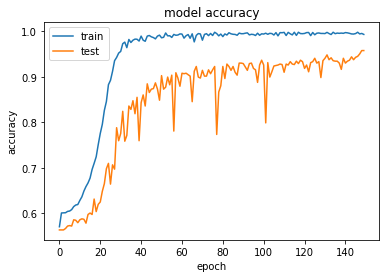

In [21]:
plot_accuracy_curve(history)

In [22]:
def plot_loss_curve(history): 
    '''
    Plot the loss curve : evolution of model loss when performing 
    on the train dataset and test dataset. 
    Save the file into png file. 
    '''
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

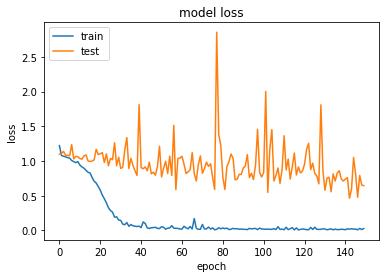

In [23]:
plot_loss_curve(history)

## 4. Visualization of predictions for test set (confusion matrix) and statistical analysis

To confirm all the parameters of the neural network it's necessary to run it on test set (reminder : this set has not been read for training purposes)
So the test set is run with calculated weights of neurons to predict classes, and it's possible to obtain the prediction rate by comparing  predicted and real categories
To visualize predictions and real values on test set, a confusion matrix was computed and plotted thanks to the 'plot_confusion_matrix' function

In [24]:
print('Predicting on test data')
y_pred = np.rint(model_info.predict(X_test))
print("Accuracy score :", accuracy_score(y_test,y_pred))

Predicting on test data
Accuracy score : 0.9495798319327731


In [25]:
classes = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'] ##alphabetical order of label
def plot_confusion_matrix(model_name):
    # Predict the values from the validation dataset
    Y_pred = np.rint(model_name.predict(X_test))

    # Because Y_pred is an array of probabilities, we have to convert it to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred, axis=1)
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(y_test, axis=1)
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
    confusion_mtx = pd.DataFrame(
        confusion_mtx,columns=classes, index=classes
    )
    # plot the confusion matrix
    plt.figure(figsize=[8, 8])
    sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt='.0f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("all_cm.png")
    plt.show()
    
    return confusion_mtx

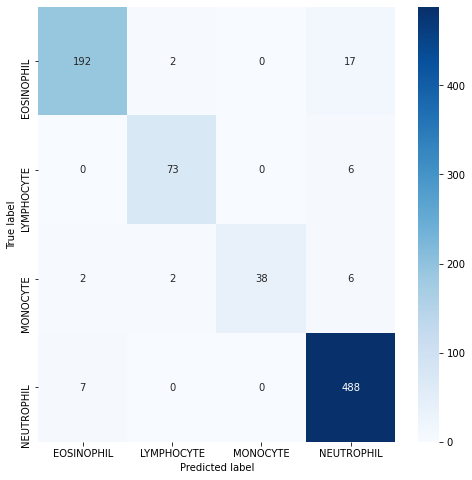

In [26]:
cm = plot_confusion_matrix(model_info)

In [27]:
def precision_score(cm):
    '''
    Function to calculate the precision score of our model.
    '''
    cm = cm.to_numpy()
    correct_preds = 0
    total_preds = 0
    for i in range(len(cm)):
        total_preds += sum(cm[i])
        correct_preds += cm[i][i]
    return round(correct_preds / total_preds * 100, 2)

In [28]:
print(f"The precision rate of this classification is : {precision_score(cm)}")

The precision rate of this classification is : 94.96


In [29]:
def confusion_tables(cm, classes):
    '''
    Function to make for each class predicted by the model, the corresponding confusion table. 
    Returns a list of the confusion tables. 
    '''
    conf_tables = []
    cm = cm.to_numpy()
    for i in range(len(classes)):
        conf_table = [[0,0],[0,0]]
        conf_table[0][0] = cm[i][i]
        conf_table[1][0] = sum(cm[i]) - conf_table[0][0]
        conf_table[0][1] = sum([cm[j][i] for j in range(0, len(classes))]) - cm[i][i]
        conf_table[1][1] = sum([sum(cm[j]) for j in range(0, len(classes))]) - sum(cm[i]) - conf_table[0][1]
        conf_tables.append(conf_table)
    return conf_tables

In [30]:
for i in range(len(classes)):
    print(f"Confusion table for class {classes[i]}")
    print("\t\t\t\tClass\tOthers\tTotal")
    print(f"Predicted in class\t\t{confusion_tables(cm, classes)[i][0][0]}\t{confusion_tables(cm, classes)[i][0][1]}\t{confusion_tables(cm, classes)[i][0][1] + confusion_tables(cm, classes)[i][0][0]}")
    print(f"Predicted in other class\t{confusion_tables(cm, classes)[i][1][0]}\t{confusion_tables(cm, classes)[i][1][1]}\t{confusion_tables(cm, classes)[i][1][1] + confusion_tables(cm, classes)[i][0][1]}")
    print(f"Total\t\t\t\t{confusion_tables(cm, classes)[i][0][0] + confusion_tables(cm, classes)[i][1][0]}\t{confusion_tables(cm, classes)[i][0][1] + confusion_tables(cm, classes)[i][1][1]}\t{confusion_tables(cm, classes)[i][0][0] + confusion_tables(cm, classes)[i][0][1] + confusion_tables(cm, classes)[i][1][0] + confusion_tables(cm, classes)[i][1][1]}\n")

Confusion table for class EOSINOPHIL
				Class	Others	Total
Predicted in class		192	9	201
Predicted in other class	19	613	622
Total				211	622	833

Confusion table for class LYMPHOCYTE
				Class	Others	Total
Predicted in class		73	4	77
Predicted in other class	6	750	754
Total				79	754	833

Confusion table for class MONOCYTE
				Class	Others	Total
Predicted in class		38	0	38
Predicted in other class	10	785	785
Total				48	785	833

Confusion table for class NEUTROPHIL
				Class	Others	Total
Predicted in class		488	29	517
Predicted in other class	7	309	338
Total				495	338	833



After recuperation of all results, sensitivity and specificity of the model was calculated to obtain some statistical values to analyse precision of the model.

In [31]:
def sensitivity(confusion_table):
    '''
    Calculates the sensitivity of a model for the class corresponding to the confusion table in parameter.
    '''
    return round(confusion_table[0][0] / (confusion_table[0][0] + confusion_table[1][0]), 2)

In [32]:
def specificity(confusion_table):
    '''
    Calculates the specificity of a model for the class corresponding to the confusion table in parameter.
    '''
    return round(confusion_table[1][1] / (confusion_table[1][1] + confusion_table[0][1]), 2)

In [33]:
for i in range(len(classes)):
    print(f"Sensitivity of the test prediction for {classes[i]} : {sensitivity(confusion_tables(cm, classes)[i])}")
    print(f"Specificity of the test prediction for {classes[i]} : {specificity(confusion_tables(cm, classes)[i])}\n")

Sensitivity of the test prediction for EOSINOPHIL : 0.91
Specificity of the test prediction for EOSINOPHIL : 0.99

Sensitivity of the test prediction for LYMPHOCYTE : 0.92
Specificity of the test prediction for LYMPHOCYTE : 0.99

Sensitivity of the test prediction for MONOCYTE : 0.79
Specificity of the test prediction for MONOCYTE : 1.0

Sensitivity of the test prediction for NEUTROPHIL : 0.99
Specificity of the test prediction for NEUTROPHIL : 0.91




## 5. Analysis of the confusion matrix, confusion tables and sensitivity/specificity values
 
After many calculs, we can see that our CNN has a prediction rate of approximately **95%** an average for all classes. 

But when we look at the classes separately, we can see that the test performs differently depending on the classes to predict. To visualize this, we calculated the sensitivity and the specificity of the test for each class. 

The **sensitivity** measures the proportion of positives that are correctly identified. It corresponds to the probability for an individual to be predicted in the class in which he should be. 
 
The **specificity** measures the proportion of negatives that are correctly identified. It corresponds to the probability for an individual not to be predicted in a class in which he should not be. 
 
Here we can see that for most of the classes, the specificity is quite good but not the sensitivity. It means that our test performs well when it says that an image does not belong to each or each class but does not performs well when it has to identify to which class corresponds to the cell in the image. 
 
However, the sensitivity is high for the Monocytes, it means that the test performs good at identifying a Monocyte when the image represents indeed a Monocyte. But for the Monocytes, the specificity is not really high compared to the others classes. 
 
We can say that our CNN is good at identifying Monocytes but identifies too many cells as a Monocyte while they are not Monocytes. It could be interesting to see how our algorithm behaves if we remove the Monocyte from the dataset. 


## 6. Use of model and weights on new pictures 

In [34]:

"""
The function "load_image" is used to transform other pictures (different of original dataset) as array to test our CNN on these pictures

Prediction is returned with array :
    - [1., 0., 0., 0.] for Eosinophil
    - [0., 1., 0., 0.] for Lymphocyte
    - [0., 0., 1., 0.] for Monocyte
    - [0., 0., 0., 1.] for Neutrophil
    
"""
def load_images(img_filename_list):
    X = []
    for img_filename in img_filename_list:
        img_file = cv2.imread(str(img_filename))
        if img_file is not None :           
            #img_file = cv2.cvtColor(img_file,cv2.COLOR_BGR2RGB)
            #img_file = cv2.cvtColor(img_file,cv2.COLOR_BGR2HSV)
            img_file = np.array(Image.fromarray(img_file).resize((160,120)))

            X.append(img_file)
            
    X = np.asarray(X)
    return X

other_img_filenames = [ "../input/final-test-datas/eosinophil.jpg", "../input/final-test-datas/lymphocyte.jpg", "../input/final-test-datas/monocyte.jpg", "../input/final-test-datas/neutrophil.jpg"]
X_other_img = load_images(other_img_filenames)
y_other_pred = np.rint(model_info.predict(X_other_img))

In [35]:
def to_classe(pred):
    if pred == [0., 1., 0., 0.]:
        return 1
    elif pred == [1., 0., 0., 0.]:
        return 0
    elif pred == [0., 0., 1., 0.]:
        return 2
    else:
        return 3

In [36]:
for i in range(len(y_other_pred)):
    if int(to_classe(list(y_other_pred[i]))) < len(classes):
        print(f"Image n°{i+1} predicted as : {classes[int(to_classe(list(y_other_pred[i])))]}")
    else:
        print(f"Image n°{i+1} not predicted.")

Image n°1 predicted as : NEUTROPHIL
Image n°2 predicted as : LYMPHOCYTE
Image n°3 predicted as : NEUTROPHIL
Image n°4 predicted as : NEUTROPHIL


## 7. Conclusion & discussion

The main **goal** of this project was to develop an **automatic recognition** of **white blood cell** pictures : monocytes, eosinophils, lymphocytes and neutrophils, to solve this problem a convolution neural network was used.

This technology allows to detect some pattern, invisible to the human eye, thanks to **layers of convolution** and utilization of **filters** : modifie the original picture,by adding more contrast or more pixelisation for example, to highlight specific pattern for each picture ; and the **"pooling"** : to group some pixels together, it depends of the size of "kernel". The most important part of work was based on the research of the model of the neural network and its parameters. 

Many research and git deposit were done : we tried several models with different adjustment. After many change of parameters (batch size, number of epoch, dropout,...), the following results were found with an **average test accuracy of 95%**. Some statistical calculus were made to analyse the confusion matrix that compares all predicted labels with real labels.

At the end of the project, we tried to predict the label of new pictures (found on internet and completly different from our original dataset) with same model and weights. Results aren't correct for all pictures and some difficulties have been encountered. This problem was certainly due to the learning on "real picture" and "augmentated pictures": maybe some patterns are visible only on "augmentated picture" and not recognized in "real pictures". Overall results on training, validation and test sets are quite satisfaying, more work is necessary to predict good labels on other pictures. 

We are conscious that our model and parameters can be improve with more time and a bigger and more various dataset. In fact, different classes are not fairly represented, there are more neutrophiles and eosinophils than lymphocytes and monocytes. It was not possible at the beginning to equilibrate all classes because we would have lost too many pictures.


### Propositions in order to improve the model

Our model suffers from **overfitting**, which means that we can predict blood cells type with high accuracy on our training dataset, but our model fails to predict with the same accuracy on the test datasets. This is probably because we worked with an unbalanced dataset with much more neutrophils than other cells. Although this is the representative biological distribution in human body, it induces a bias in our model. A solution for this problem could be to normalize the classes in order to have the same number of individuals in each class. We could use a **SMOTE / SMNRT** augmentation on the dataset, which is a method to create synthetic images based on their pixel values, and re-train our model with the synthetic images.

Due to the importance of image classification, many Deep-learning classification models exists, and we could also try to implement pre-trained models on our dataset. In the notebook associated with the dataset, they used the LeNet model, but they only chose to differenciate polynuclear cells (Eosinophil/Neutrophil) from mononuclear cells (Monocytes/Lymphocyte) whereas in our notebook, we tried to differentiate each classes. They also tried to use a VGGNet model, but they failed to obtain good results because they used a model trained on general images (e.g cats, dogs...) and not specially on cells pictures. Another solution would be to thoroughly search pretrained models (AlexNet, GoogleNet, Xception...) and look for models that learned on blood cells images.